In [55]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('./data/train_macro.csv', index_col=0, parse_dates=['timestamp'])
df_test_macro = pd.read_csv('./data/test_macro.csv', index_col=0, parse_dates=['timestamp'])

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names

## Column Names

Replace -, +, :, ~, * in column name with underscore

In [2]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns.drop('_timestamp')) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

# Log Transformation

Transform data with skewness greater than 1.

In [3]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [4]:
def make_statsmodels_ols_formula(numeric_ivs, categorical_ivs, dv, log_vs=[], degree=1, scale=True):


    if len(log_vs) > 0:
        numeric_ivs = ["np.log({})".format(iv) if iv in log_vs else iv for iv in numeric_ivs ]

    polynomials = []
    if degree > 1:
        for i in range(2, degree + 1):
            if scale:
                polynomials = list(map(lambda iv: 'scale(I({}**{}))'.format(iv, i), numeric_ivs))
            else:
                polynomials = list(map(lambda iv: 'I({}**{})'.format(iv, i), numeric_ivs))
    
    if scale:
        numeric_ivs = ["scale({})".format(iv) if scale else iv for iv in numeric_ivs ]

    formula = ''
    if dv in log_vs:
        formula = 'np.log({}) ~ '.format(dv)
    else:
        formula = '{} ~ '.format(dv)
    

    if len(categorical_ivs) > 0:
        if len(numeric_ivs) > 0:
            formula += " + ".join(list(map(lambda iv: 'C({})'.format(iv), categorical_ivs)))
        else:
            formula += " + ".join(list(map(lambda iv: 'C({})-1'.format(iv), categorical_ivs)))
    
    if len(polynomials) > 0:
        if len(categorical_ivs) > 0:
            return  formula + " + " + " + ".join(numeric_ivs) + " + " + " + ".join(polynomials)
        else:
            return  formula + " + ".join(numeric_ivs) + " + " + " + ".join(polynomials)
    else:
        if len(categorical_ivs) > 0:
            return formula + " + " + " + ".join(numeric_ivs)
        else:
            return formula + " + ".join(numeric_ivs) 


In [5]:
formula = make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     177.7
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:21:36   Log-Likelihood:                -20136.
No. Observations:               30404   AIC:                         4.049e+04
Df Residuals:                   30296   BIC:                         4.139e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 12.7973      1.628      7.859      0.000       9.606      15.989
C(_railroad_terminal_raion)[T.yes]                         0.0339      0.027      1.237      0.216      -0.020       0.088
C(_big_market_raion)[T.yes]                               -0.0017      0.015     -0.115      0.909      -0.031       0.028
C(_thermal_power_plant_raion)[T.yes]                       0.0073      0.016      0.460      0.646      -0.024       0.039
C(_nuclear_reactor_raion)[T.yes]                          -0.0346      0.019     -1.790      0.073      -0.072       0.003
C(_incineration_raion)[T.yes]                              0.0022      0.021      0.105      0.916      -0.039       0.044
C(_detention_facility_raion)[T.yes]                       -0.0051      0.012     -0.417      0.677      -0.029       0.019
C(_railroad_1line)[T.yes]                                 -0.1923      0.018    -10.870      0.000      -0.227      -0.158
C(_ecology)[T.good]                                       -0.0435      0.015     -2.920      0.004      -0.073      -0.014
C(_ecology)[T.no data]                                    -0.1878      0.026     -7.164      0.000      -0.239      -0.136
C(_ecology)[T.poor]                                       -0.0079      0.013     -0.612      0.541      -0.033       0.017
C(_ecology)[T.satisfactory]                                0.0287      0.017      1.718      0.086      -0.004       0.061
C(_water_1line)[T.yes]                                    -0.0063      0.012     -0.547      0.584      -0.029       0.016
C(_big_road1_1line)[T.yes]                                -0.0240      0.019     -1.254      0.210      -0.062       0.014
C(_radiation_raion)[T.yes]                                -0.0428      0.008     -5.062      0.000      -0.059      -0.026
C(_product_type)[T.OwnerOccupier]                          0.1369      0.011     12.345      0.000       0.115       0.159
C(_culture_objects_top_25)[T.yes]                          0.0874      0.017      5.003      0.000       0.053       0.122
C(_oil_chemistry_raion)[T.yes]                            -0.0789      0.033     -2.379      0.017      -0.144      -0.014
np.log(_full_sq)                                           0.4210      0.123      3.436      0.001       0.181       0.661
np.log(_life_sq)                                           0.0348      0.029      1.197      0.231      -0.022       0.092
_floor                                                     0.0089      0.002      4.933      0.000       0.005       0.013
_num_room                                                 -0.1096      0.020     -5.433      0.000      -0.149      -0.070
np.log(_

## Condition Number

Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling

Standalize variables by removing the mean and scaling to unit variance.

In [6]:
formula = make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     177.7
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:22:05   Log-Likelihood:                -20136.
No. Observations:               30404   AIC:                         4.049e+04
Df Residuals:                   30296   BIC:                         4.139e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.6356      0.015   1024.876      0.000      15.606      15.666
C(_railroad_terminal_raion)[T.yes]                                0.0339      0.027      1.237      0.216      -0.020       0.088
C(_big_market_raion)[T.yes]                                      -0.0017      0.015     -0.115      0.909      -0.031       0.028
C(_thermal_power_plant_raion)[T.yes]                              0.0073      0.016      0.460      0.646      -0.024       0.039
C(_nuclear_reactor_raion)[T.yes]                                 -0.0346      0.019     -1.790      0.073      -0.072       0.003
C(_incineration_raion)[T.yes]                                     0.0022      0.021      0.105      0.916      -0.039       0.044
C(_detention_facility_raion)[T.yes]                              -0.0051      0.012     -0.417      0.677      -0.029       0.019
C(_railroad_1line)[T.yes]                                        -0.1923      0.018    -10.870      0.000      -0.227      -0.158
C(_ecology)[T.good]                                              -0.0435      0.015     -2.920      0.004      -0.073      -0.014
C(_ecology)[T.no data]                                           -0.1878      0.026     -7.164      0.000      -0.239      -0.136
C(_ecology)[T.poor]                                              -0.0079      0.013     -0.612      0.541      -0.033       0.017
C(_ecology)[T.satisfactory]                                       0.0287      0.017      1.718      0.086      -0.004       0.061
C(_water_1line)[T.yes]                                           -0.0063      0.012     -0.547      0.584      -0.029       0.016
C(_big_road1_1line)[T.yes]                                       -0.0240      0.019     -1.254      0.210      -0.062       0.014
C(_radiation_raion)[T.yes]                                       -0.0428      0.008     -5.062      0.000      -0.059      -0.026
C(_product_type)[T.OwnerOccupier]                                 0.1369      0.011     12.345      0.000       0.115       0.159
C(_culture_objects_top_25)[T.yes]                                 0.0874      0.017      5.003      0.000       0.053       0.122
C(_oil_chemistry_raion)[T.yes]                                   -0.0789      0.033     -2.379      0.017      -0.144      -0.014
scale(np.log(_full_sq))                                           0.1467      0.043      3.436      0.001       0.063       0.230
scale(np.log(_life_sq))                                           0.0212      0.018      1.197      0.231      -0.014       0.056
scale(_floor)                                                     0.0474      0.010      4.93

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction

## ANOVA

In [7]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_railroad_terminal_raion),0.338048,1.0,1.529901,2.161369e-01
C(_big_market_raion),0.002916,1.0,0.013195,9.085481e-01
C(_thermal_power_plant_raion),0.046687,1.0,0.211290,6.457617e-01
C(_nuclear_reactor_raion),0.707909,1.0,3.203775,7.347851e-02
C(_incineration_raion),0.002431,1.0,0.011002,9.164636e-01
C(_detention_facility_raion),0.038358,1.0,0.173597,6.769379e-01
C(_railroad_1line),26.110223,1.0,118.166761,1.791675e-27
C(_ecology),21.913810,4.0,24.793775,1.593034e-20
C(_water_1line),0.066141,1.0,0.299336,5.843033e-01
C(_big_road1_1line),0.347604,1.0,1.573150,2.097599e-01


We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

# F-test and Feature Influence

In [8]:
def by_f_test(df, formula, repeat=10, log_dv = True):
    result = None
    selected_ivs = []
    for i in range(repeat):
        model = sm.OLS.from_formula(formula, data=df)
        result = model.fit()
        anova = sm.stats.anova_lm(result, typ=2)
        selected_ivs = [iv[0] for iv in anova.iterrows() if iv[1][3] < 0.05]
        if len(selected_ivs) >= 0:
            if log_dv == True:  
                formula = 'np.log(_price_doc) ~ ' + ' + '.join(selected_ivs)
            else:
                formula = '_price_doc ~ ' + ' + '.join(selected_ivs)
        else:
            return result, selected_ivs
    return result, selected_ivs,  formula

In [9]:
result, sms_vars, formula = by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     330.4
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:24:58   Log-Likelihood:                -20200.
No. Observations:               30404   AIC:                         4.052e+04
Df Residuals:                   30346   BIC:                         4.100e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.6498      0.011   1418.017      0.000      15.628      15.671
C(_railroad_1line)[T.yes]                                        -0.1729      0.017    -10.239      0.000      -0.206      -0.140
C(_ecology)[T.good]                                              -0.0586      0.012     -4.868      0.000      -0.082      -0.035
C(_ecology)[T.no data]                                           -0.2299      0.017    -13.503      0.000      -0.263      -0.197
C(_ecology)[T.poor]                                              -0.0111      0.011     -1.000      0.318      -0.033       0.011
C(_ecology)[T.satisfactory]                                       0.0184      0.014      1.299      0.194      -0.009       0.046
C(_radiation_raion)[T.yes]                                       -0.0419      0.008     -5.423      0.000      -0.057      -0.027
C(_product_type)[T.OwnerOccupier]                                 0.1389      0.010     14.288      0.000       0.120       0.158
C(_culture_objects_top_25)[T.yes]                                 0.0797      0.016      5.102      0.000       0.049       0.110
C(_oil_chemistry_raion)[T.yes]                                   -0.0723      0.029     -2.506      0.012      -0.129      -0.016
scale(np.log(_full_sq))                                           0.1581      0.041      3.816      0.000       0.077       0.239
scale(_floor)                                                     0.0543      0.009      6.255      0.000       0.037       0.071
scale(_num_room)                                                 -0.0839      0.013     -6.368      0.000      -0.110      -0.058
scale(_state)                                                    -0.1384      0.014     -9.977      0.000      -0.166      -0.111
scale(np.log(_school_education_centers_top_20_raion))             0.2011      0.030      6.702      0.000       0.142       0.260
scale(np.log(_hospital_beds_raion))                              -0.0661      0.020     -3.328      0.001      -0.105      -0.027
scale(np.log(_healthcare_centers_raion))                          0.0271      0.004      6.482      0.000       0.019       0.035
scale(np.log(_build_count_monolith))                             -0.0160      0.006     -2.658      0.008      -0.028      -0.004
scale(np.log(_public_transport_station_min_walk))                -0.0104      0.005     -1.976      0.048      -0.021   -8.13e-05
scale(_big_road1_km)                                              0.0362      0.010      3.525      0.000       0.016       0.056
scale(np.log(_market_shop_km))                                   -0.0154      0.005     -3.37

# 3. Outlier

## Cook's Distance

Find data with large leverage and residual by calculating Cook's distance.

In [10]:
def remove_outliers(df, formula, repeat=1):
    result = None
    for i in range(repeat):
        model = sm.OLS.from_formula(formula, data=df)
        result = model.fit()
        influence = result.get_influence()
        distances, pvalues = influence.cooks_distance
        threshold = 4/(len(distances) - len(df.columns.drop(['_timestamp', '_price_doc']))-1)
        outliers = [idx for idx, d in enumerate(distances) if d > threshold]
        df.drop(df.index[outliers], inplace=True)
    return df, model, result

In [11]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = remove_outliers(df_train_macro, formula, repeat=5)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     3762.
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:26:09   Log-Likelihood:                 16632.
No. Observations:               23839   AIC:                        -3.315e+04
Df Residuals:                   23781   BIC:                        -3.268e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.7580      0.003   4588.414      0.000      15.751      15.765
C(_railroad_1line)[T.yes]                                        -0.2024      0.006    -34.659      0.000      -0.214      -0.191
C(_ecology)[T.good]                                               0.0092      0.004      2.585      0.010       0.002       0.016
C(_ecology)[T.no data]                                           -0.1464      0.005    -28.799      0.000      -0.156      -0.136
C(_ecology)[T.poor]                                               0.0419      0.003     12.457      0.000       0.035       0.049
C(_ecology)[T.satisfactory]                                       0.0793      0.004     18.611      0.000       0.071       0.088
C(_radiation_raion)[T.yes]                                       -0.0088      0.002     -3.762      0.000      -0.013      -0.004
C(_product_type)[T.OwnerOccupier]                                -0.0963      0.003    -31.355      0.000      -0.102      -0.090
C(_culture_objects_top_25)[T.yes]                                 0.1527      0.005     29.396      0.000       0.143       0.163
C(_oil_chemistry_raion)[T.yes]                                   -0.0404      0.009     -4.707      0.000      -0.057      -0.024
scale(np.log(_full_sq))                                           0.1283      0.016      8.146      0.000       0.097       0.159
scale(_floor)                                                     0.0612      0.003     22.477      0.000       0.056       0.067
scale(_num_room)                                                 -0.0544      0.004    -12.913      0.000      -0.063      -0.046
scale(_state)                                                    -0.1388      0.004    -34.603      0.000      -0.147      -0.131
scale(np.log(_school_education_centers_top_20_raion))             0.1410      0.011     12.989      0.000       0.120       0.162
scale(np.log(_hospital_beds_raion))                              -0.0151      0.006     -2.419      0.016      -0.027      -0.003
scale(np.log(_healthcare_centers_raion))                          0.0196      0.001     15.264      0.000       0.017       0.022
scale(np.log(_build_count_monolith))                             -0.0016      0.002     -0.897      0.370      -0.005       0.002
scale(np.log(_public_transport_station_min_walk))                 0.0145      0.002      8.909      0.000       0.011       0.018
scale(_big_road1_km)                                              0.0290      0.003      9.405      0.000       0.023       0.035
scale(np.log(_market_shop_km))                                   -0.0054      0.001     -3.89

# 4. Regularization

## Lasso

Find variables with zero coefficient when Lasso regularization is applied.

In [12]:
# result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [13]:
# sms_vars = []
# for idx, coef in enumerate(result_lasso.params):
#     if coef ==0:
#         continue
#     feature = result_lasso.params.index[idx]
#     if feature == 'Intercept':
#         continue
#     startDelPos = feature.find('[')
#     endDelPos = feature.find(']')
#     feature = feature.replace(feature[startDelPos:endDelPos+1], '')
#     sms_vars.append(feature)

In [14]:
# formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
# model = sm.OLS.from_formula(formula, data=df_train_macro)
# result = model.fit()
# result.summary()

# 5. Diagnosis of Regression

## Residual Normality Test

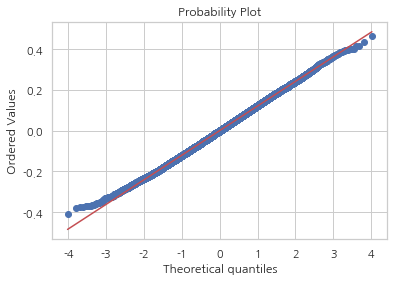

In [15]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [16]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 44.599
P-value     :  0.000


## Partial Regression Plot

Let's visualize the influence of a single independent variable.

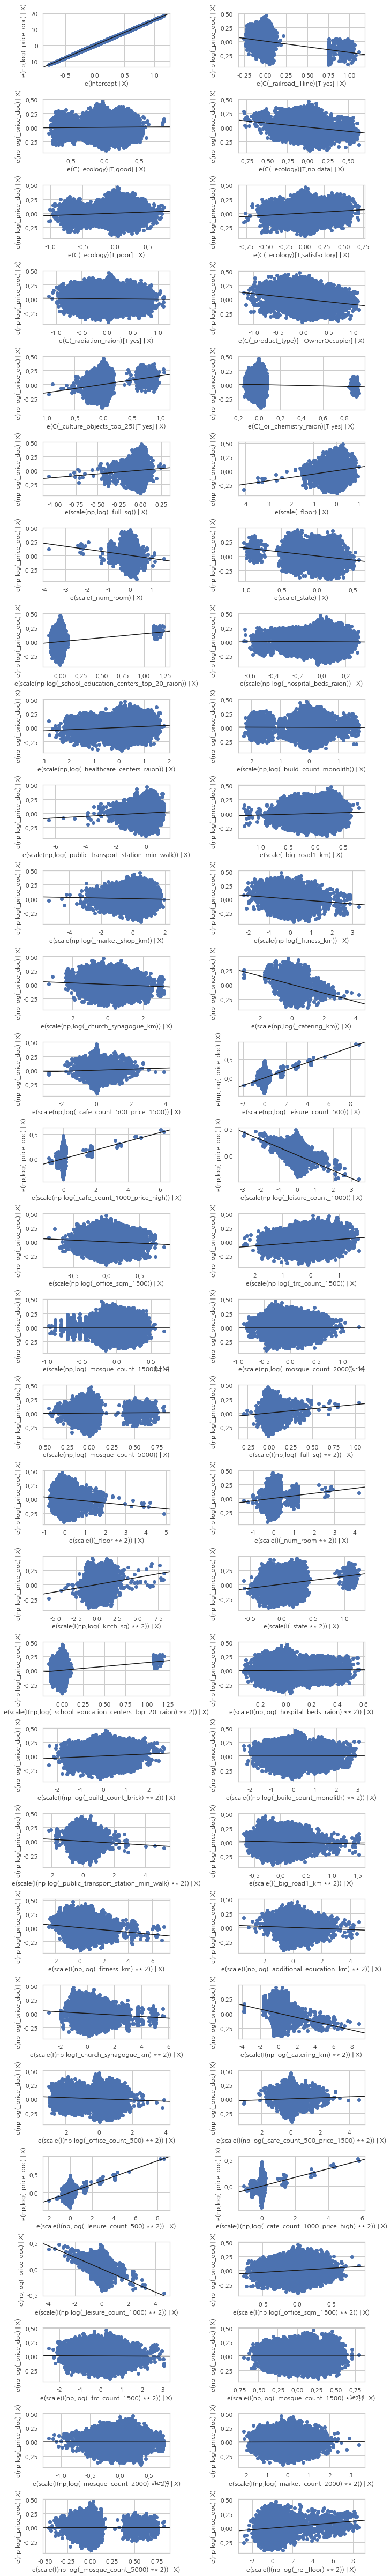

In [17]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [18]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.3676827659662561

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,  3.,  0.,  2.,  4.,
         1.,  2.,  5.,  4.,  3.,  2.,  4.,  3., 11.,  4.,  7.,  8.,  9.,
        10.,  6., 12., 12., 11., 13., 19., 16., 22., 28., 21., 25., 28.,
        28., 21., 32., 37., 32., 23., 33., 33., 35., 36., 27., 29., 24.,
        30., 21., 34., 23., 17., 27., 20., 17., 15., 16., 19., 15., 11.,
        10., 13.,  7.,  2.,  3.,  0.,  1.,  4.,  2.]),
 array([-0.80049649, -0.78400152, -0.76750655, -0.75101158, -0.73451661,
        -0.71802164, -0.70152667, -0.68503171, -0.66853674, -0.65204177,
        -0.6355468 , -0.61905183, -0.60255686, -0.58606189, -0.56956692,
        -0.55307195, -0.53657698, -0.52008201, -0.50358705, -0.48709208,
        -0.47059711, -0.45410214, -0.43760717, -0.4211122 , -0.40461723,
        -0.38812226, -0.37162729, -0.35513232, -0.33863735, -0.322142

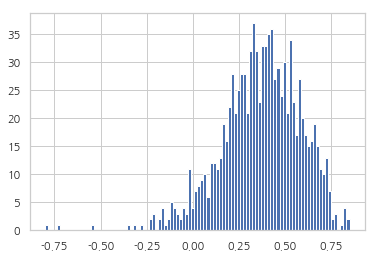

In [19]:
plt.hist(r2s, bins=100)

In [20]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('./data/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

In [53]:
def rmsle(predicted,real):
    s=0.0
    for x in range(len(predicted)):
        if predicted[x] <= 0: 
            Exception('값이 마이너스가 될수 없습니다.')
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        s = s + (p - r)**2
    return (s/len(predicted))**0.5

In [41]:
real_price = pd.read_csv('./data/sample_submission.csv', index_col=0)
np.exp(real_price)

,price_doc
id,
30474,inf
30475,inf
30476,inf
30477,inf
30478,inf
30479,inf
30480,inf
30481,inf
30482,inf


In [50]:
np.log(y_pred.values+1)

array([[15.67792201],
       [15.83678418],
       [15.62951246],
       ...,
       [15.41460069],
       [15.63690339],
       [16.16586403]])

In [51]:
np.log(real_price.values+1)

array([[15.77820779],
       [15.77820779],
       [15.77820779],
       ...,
       [15.77820779],
       [15.77820779],
       [15.77820779]])

In [54]:
rmsle(np.log(y_pred.values+1), np.log(real_price.values+1))

array([inf])